In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Set up paths
PYTHONPATH = "/global/homes/b/bpb/repos/envnet"
os.environ['PYTHONPATH'] = PYTHONPATH

# Import ENVnet
import sys
sys.path.insert(0, PYTHONPATH)
from envnet.build import quick_envnet
from envnet.config.build_config import BuildConfig
from envnet.build import ENVnetBuilder

output_dir = Path(os.path.join(PYTHONPATH, "results", "temp_data"))
output_dir.mkdir(parents=True, exist_ok=True)

# Create config
config = BuildConfig()
config.min_score = 0.6  # Lower threshold for testing
config.remblink_cutoff = 0.01
config.network_max_mz_difference = 50.0
config.min_cluster_size = 1


In [11]:


parquet_file = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20221110_EB_MdR_101544-059_HumicAcid_20221110_EXP120A_C18-EP_USDAY63672_NEG_MS2_11_HumicAcid-KOH-nonfiltr-NA-NA_1__078.parquet'
print(f"Loading: {parquet_file}")
df = pd.read_parquet(parquet_file)

print(f"Total spectra in file: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"Precursor m/z range: {df['precursor_mz'].min():.3f} - {df['precursor_mz'].max():.3f}")

df.rename(columns={
    'mdm_mz_vals': 'deconvoluted_spectrum_mz_vals',
    'mdm_i_vals': 'deconvoluted_spectrum_intensity_vals',
    'original_mz_vals':'original_spectrum_mz_vals',
    'original_i_vals':'original_spectrum_intensity_vals'
}, inplace=True)

df['basename'] = df['filename'].apply(lambda x: os.path.basename(x))
# df.index.name = 'original_index'
# df.reset_index(drop=False, inplace=True)
df.head()


Loading: /global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20221110_EB_MdR_101544-059_HumicAcid_20221110_EXP120A_C18-EP_USDAY63672_NEG_MS2_11_HumicAcid-KOH-nonfiltr-NA-NA_1__078.parquet
Total spectra in file: 216
Columns: ['cluster', 'precursor_mz', 'isolated_precursor_mz', 'rt', 'filename', 'coisolated_precursor_count', 'mdm_mz_vals', 'mdm_i_vals', 'original_mz_vals', 'original_i_vals', 'predicted_formula', 'estimated_fdr']
Precursor m/z range: 85.027 - 591.220


,cluster,precursor_mz,isolated_precursor_mz,rt,filename,coisolated_precursor_count,deconvoluted_spectrum_mz_vals,deconvoluted_spectrum_intensity_vals,original_spectrum_mz_vals,original_spectrum_intensity_vals,predicted_formula,estimated_fdr,basename
0,23,85.026703,84.990555,9.573406,/global/cfs/cdirs/metatlas/projects/carbon_net...,2,"[41.03777313232422, 43.017662048339844, 67.013...","[1164.2669677734375, 1092.9249267578125, 1201....","[40.38612365722656, 59.822776794433594, 67.013...","[1617.525390625, 1389.0322265625, 1201.3072509...",H2N6,0.0,20221110_EB_MdR_101544-059_HumicAcid_20221110_...
1,80,89.024302,88.987930,11.400856,/global/cfs/cdirs/metatlas/projects/carbon_net...,1,"[59.013275146484375, 59.01355743408203, 59.013...","[1932.5098876953125, 1487.2332763671875, 1387....","[89.02423095703125, 88.98790740966797, 60.9967...","[13320.5166015625, 14817.9658203125, 1782.0925...",C3H6O3,0.0,20221110_EB_MdR_101544-059_HumicAcid_20221110_...
2,167,99.118536,98.948906,9.342418,/global/cfs/cdirs/metatlas/projects/carbon_net...,1,"[43.06032180786133, 55.0954475402832, 70.11597...","[1421.1280517578125, 1410.1922607421875, 1434....","[85.5282211303711, 108.79478454589844, 100.908...","[1273.975341796875, 1299.6181640625, 1417.0789...",C7H16,0.0,20221110_EB_MdR_101544-059_HumicAcid_20221110_...
3,203,100.003901,99.925575,1.503489,/global/cfs/cdirs/metatlas/projects/carbon_net...,1,"[72.99296569824219, 72.99298095703125, 72.9929...","[27504.388671875, 6628.23974609375, 30990.8222...","[99.92579650878906, 72.99298095703125]","[7064.74853515625, 6628.23974609375]",C3H3NO3,0.0,20221110_EB_MdR_101544-059_HumicAcid_20221110_...
4,264,100.982393,100.933502,5.935612,/global/cfs/cdirs/metatlas/projects/carbon_net...,1,"[68.9560546875, 68.95609283447266, 68.95610809...","[1187.2337646484375, 1511.3192138671875, 1677....","[115.92060089111328, 100.94574737548828, 100.9...","[4883.25146484375, 6714.56640625, 48528.078125...",C2H2N2OS,0.0,20221110_EB_MdR_101544-059_HumicAcid_20221110_...


In [3]:

# # 2. Select strategic spectra for testing
# # Goal: Pick some that should cluster together and some that shouldn't

# # Strategy 1: Pick spectra with similar m/z (should connect if similar fragmentation)
# similar_mz_group = df[
#     (df['precursor_mz'] >= 200) & (df['precursor_mz'] <= 210)
# ].head(5)

# # Strategy 2: Pick spectra with very different m/z (should NOT connect)  
# different_mz_1 = df[
#     (df['precursor_mz'] >= 300) & (df['precursor_mz'] <= 310)
# ].head(3)

# different_mz_2 = df[
#     (df['precursor_mz'] >= 500) & (df['precursor_mz'] <= 510)
# ].head(3)

# # Strategy 3: Pick a few random ones
# random_spectra = df.sample(n=min(5, len(df)), random_state=42)

# # Combine all test spectra
# test_spectra = pd.concat([
#     similar_mz_group,
#     different_mz_1, 
#     different_mz_2,
#     random_spectra
# ]).head(15).reset_index(drop=True)  # Limit to 15 spectra



# print(f"\nSelected {len(test_spectra)} test spectra:")
# print("Similar m/z group (should potentially connect):")
# for _, row in similar_mz_group.iterrows():
#     print(f"  m/z: {row['precursor_mz']:.3f}")

# print("Different m/z groups (should be separate):")
# for _, row in different_mz_1.iterrows():
#     print(f"  m/z: {row['precursor_mz']:.3f}")
# for _, row in different_mz_2.iterrows():
#     print(f"  m/z: {row['precursor_mz']:.3f}")





In [12]:
test_spectra = df.copy()

builder = ENVnetBuilder(config=config, verbose=True)
# IMPORTANT: Preprocess the spectra
print("Preprocessing spectra...")
test_spectra = builder.workflows.data_loader._preprocess_spectra(test_spectra)

# Mock the data loading by directly setting the spectra
builder.workflows.data_loader.all_spectra = test_spectra.copy()

# Run library matching
print("Running library matching...")
deconv_matches = builder.workflows.library_matcher.score_all_spectra(test_spectra, scoring_type='deconvoluted')
orig_matches = builder.workflows.library_matcher.score_all_spectra(test_spectra, scoring_type='original')

# Run clustering
print("Running clustering...")
clustered_spectra = builder.workflows.clusterer.cluster_duplicate_spectra(test_spectra)

# Eliminate redundant spectra
print("Eliminating redundant spectra...")
node_data = builder.workflows.clusterer.eliminate_redundant_spectra(
    clustered_spectra, deconv_matches, orig_matches
)

# Build network
print("Building network...")
network = builder.workflows.network_builder.build_remblink_network(node_data)

ENVnet Builder initialized
Preprocessing spectra...
Running library matching...
Processing deconvoluted 20221110_EB_MdR_101544-059_HumicAcid_20221110_EXP120A_C18-EP_USDAY63672_NEG_MS2_11_HumicAcid-KOH-nonfiltr-NA-NA_1__078.h5 - found 26 matches
Processing original 20221110_EB_MdR_101544-059_HumicAcid_20221110_EXP120A_C18-EP_USDAY63672_NEG_MS2_11_HumicAcid-KOH-nonfiltr-NA-NA_1__078.h5 - found 13 matches
Running clustering...
Chunking spectra into groups based on precursor m/z...
Found 66 unique precursor m/z groups
Counter: 0, Processing 1 entries for m/z range 89.0243 to 89.0243, Found 1 unique spectra
Counter: 1, Processing 1 entries for m/z range 100.0039 to 100.0039, Found 1 unique spectra
Counter: 2, Processing 1 entries for m/z range 113.0244 to 113.0244, Found 1 unique spectra
Counter: 3, Processing 1 entries for m/z range 113.0356 to 113.0356, Found 1 unique spectra
Counter: 4, Processing 1 entries for m/z range 115.0035 to 115.0035, Found 1 unique spectra
Counter: 5, Processing

/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
network.nodes()

NodeView(())


=== Network Analysis ===
Component sizes: [31, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Component 1 (31 nodes):
  Node 1: m/z=89.024
  Node 3: m/z=100.004
  Node 133: m/z=206.964
  Node 134: m/z=206.978
  Node 135: m/z=207.030
  Node 137: m/z=207.931
  Node 12: m/z=113.024
  Node 14: m/z=113.036
  Node 17: m/z=115.004
  Node 20: m/z=116.035
  Node 150: m/z=223.025
  Node 23: m/z=117.019
  Node 152: m/z=225.004
  Node 29: m/z=130.015
  Node 159: m/z=231.931
  Node 167: m/z=239.903
  Node 51: m/z=146.009
  Node 60: m/z=157.050
  Node 61: m/z=158.978
  Node 64: m/z=160.976
  Node 65: m/z=162.982
  Node 67: m/z=173.926
  Node 70: m/z=174.926
  Node 78: m/z=178.948
  Node 79: m/z=178.978
  Node 80: m/z=178.983
  Node 84: m/z=179.035
  Node 105: m/z=187.097
  Node 114: m/z=190.998
  Node 122: m/z=195.030
  Node 124: m/z=197.009

Component 2 (1 nodes):
  Node 89: m/z=181.072

Component 3 (3 nodes):
  Node 145: m/z=215.128
  Node 154: m/z=229.144
  

/tmp/ipykernel_1122010/1293311473.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'),


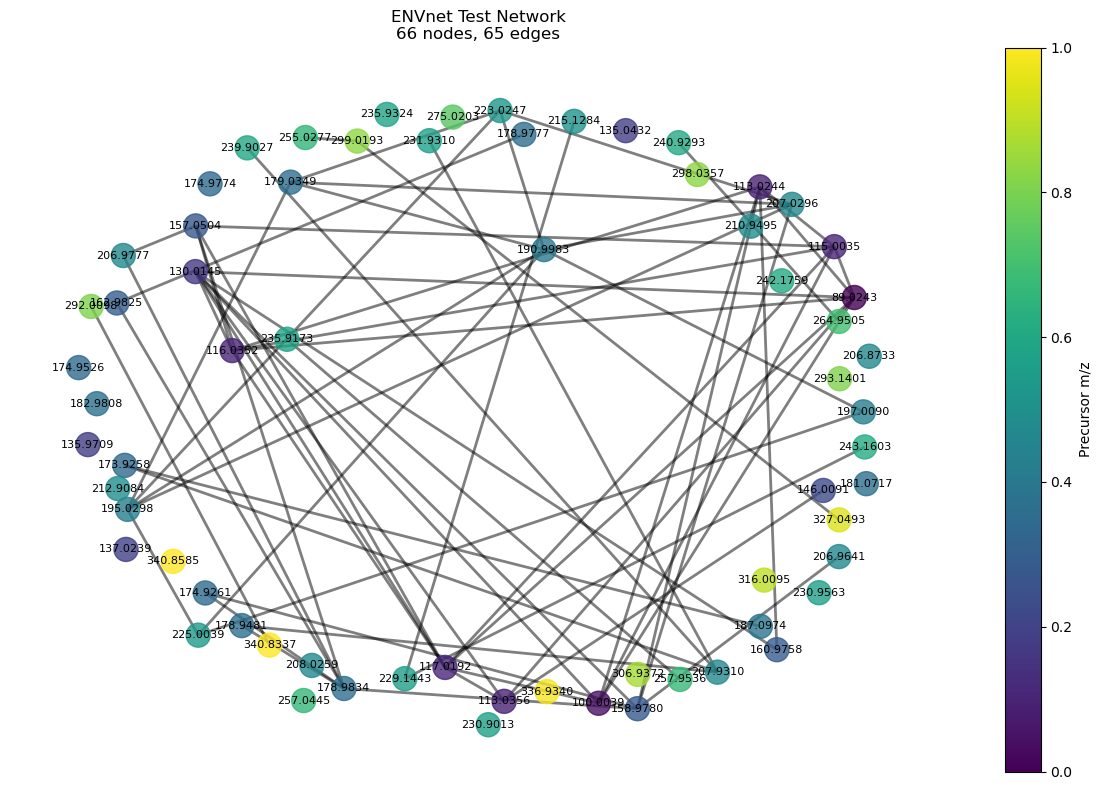


=== Validation ===
Similar m/z spectra connected: False

✅ ENVnet build completed successfully!
Network saved to: /global/homes/b/bpb/repos/envnet/results/temp_data


In [15]:


# 6. Analyze and visualize the network
print(f"\n=== Network Analysis ===")

# Get connected components
components = list(nx.connected_components(network))
print(f"Component sizes: {[len(c) for c in components]}")

# Print details about each component
for i, component in enumerate(components):
    print(f"\nComponent {i+1} ({len(component)} nodes):")
    for node in component:
        node_info = network.nodes[node]
        print(f"  Node {node}: m/z={node_info.get('precursor_mz', 'N/A'):.3f}")

# 7. Visualize the network
plt.figure(figsize=(12, 8))

# Create layout
if network.number_of_nodes() > 0:
    pos = nx.spring_layout(network, k=2, iterations=50)
    
    # Draw nodes colored by precursor m/z
    node_colors = [network.nodes[node].get('precursor_mz', 0) for node in network.nodes()]
    
    nx.draw_networkx_nodes(network, pos, 
                            node_color=node_colors, 
                            node_size=300,
                            cmap='viridis',
                            alpha=0.8)
    
    nx.draw_networkx_edges(network, pos, alpha=0.5, width=2)
    
    # Add labels with m/z values
    labels = {node: f"{network.nodes[node].get('precursor_mz', 0):.4f}" 
                for node in network.nodes()}
    nx.draw_networkx_labels(network, pos, labels, font_size=8)
    
    plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), 
                label='Precursor m/z')
    plt.title(f"ENVnet Test Network\n{network.number_of_nodes()} nodes, {network.number_of_edges()} edges")
    
else:
    plt.text(0.5, 0.5, "No network generated", 
            horizontalalignment='center', verticalalignment='center')
    plt.title("ENVnet Test - No Network")

plt.axis('off')
plt.tight_layout()
# plt.savefig('/tmp/envnet_test_network.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Validation checks
print(f"\n=== Validation ===")

# Check if similar m/z spectra are connected (they should be if they have similar fragmentation)
similar_nodes = [node for node in network.nodes() 
                if 200 <= network.nodes[node].get('precursor_mz', 0) <= 210]

if len(similar_nodes) > 1:
    similar_connected = any(network.has_edge(similar_nodes[0], other) 
                            for other in similar_nodes[1:])
    print(f"Similar m/z spectra connected: {similar_connected}")

# Check that very different m/z spectra are NOT connected
very_different = []
for node in network.nodes():
    mz = network.nodes[node].get('precursor_mz', 0)
    if 300 <= mz <= 310 or 500 <= mz <= 510:
        very_different.append((node, mz))

if len(very_different) > 1:
    different_connected = any(network.has_edge(very_different[0][0], other[0]) 
                            for other in very_different[1:])
    print(f"Very different m/z spectra connected: {different_connected} (should be False)")

print(f"\n✅ ENVnet build completed successfully!")
print(f"Network saved to: {output_dir}")
# print(f"Visualization saved to: /tmp/envnet_test_network.png")

